In [1]:
# This is the simulation of our evolving RS model under the FIRST framework of our assumptions on edge weights.
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import pandas as pd
import random
import seaborn as sns

In [62]:
#Initial settings of parameters in our weighted bipartite graph model B(U,I).
beta = 0.6 # the probability to add a new vertex in U
iterations = 3000 # the number of iterations to run the simulation
rating_scale = 5 # the preassigned rating scale
Cu = 10 # the least number of edges connected to vertices in U
Ci = 20 # the least number of edges connected to vertices in I
Unum = 20 # the number of vertices in U in the initial graph at t=0
Inum = 10 # the number of vertices in I in the initial graph at t=1
K = 10 # the number of basic user type in our assumption
L = 5 # the number of basic item level in our assumption
C = 1
Huser = np.zeros((K,rating_scale)) # the rating pmf for the K user types
Hitem = np.zeros((L,rating_scale)) # the rating pmf for the L item levels
Fmean = np.zeros((K,)) # the mean of the distribution of users' weight vector (assumed to be Gaussian)
Gmean = np.zeros((L,)) # the mean of the distribution of items' weight vector (assumed to be Gaussian)
edges = np.zeros((iterations+50,iterations+50), dtype=int) # the matrix storing edge information

In [64]:
# Sample edge weight(s) for new users in U from the mixture distribution
def userweightgenerator(nb):
    global K,L,Huser,Hitem,rating_scale,Fmean,Gmean
    Uvec = np.random.normal(Fmean,0.1)
    Uvec[Uvec<0]=0
    Uvec = Uvec/np.sum(Uvec)
    Uvec = np.array([Uvec]*rating_scale)
    Uvec = np.transpose(Uvec)
    Hu = Huser*Uvec
    Hu = np.sum(Hu,axis=0)
    R = np.random.choice(rating_scale,nb,p=Hu)+1
    return R

In [69]:
# Initialization for the inital simple graph at t=0
def init():
    print('Initalizing...')
    global edges,Unum,Inum
    init_weightgenerator()
    edges = np.zeros((iterations+50,iterations+50), dtype=int)
    # We can assume that axis=1 is user sequence and the axis=0 is the item sequence
    for i in range(Unum):
        edges[i,0:Inum] = userweightgenerator(Inum)
    print('Done.')

In [ ]:
# Select "prototype" from the existing vertex group
def prototype(arr, nb):
    return np.count_nonzero(arr.cumsum() < nb)

# Conduct Edge-copy and assign new edge weights
def copyedge(template, desired,p_prime):
    ls = []
    new2old = template.nonzero()[0]
    tmp = template[new2old].astype(float)
    for i in range(desired):
        tmp /= tmp.sum()
        sampled = np.nonzero(np.random.multinomial(1, tmp))[0][0]
        ls.append(sampled)
        tmp[sampled] = 0
    ls.sort()
    return new2old[ls]

# Add new vertices to U (respectively. I)
def addnode(nb_axis):
    global edges,Unum,Inum
    weightsum = np.sum(edges[:Unum,:Inum], axis=nb_axis)
    totalsum = np.sum(weightsum)
    randnum = np.random.randint(1, totalsum+1)
    p_prime = prototype(weightsum, randnum)
    weighted = np.zeros(1)
    if nb_axis == 1:
        template = edges[p_prime, :Inum]
        desired = Cu
        weighted = userweightgenerator(template.shape[0])
    else:
        template = edges[:Unum, p_prime]
        desired = Ci
        weighted = itemweightgenerator(template.shape[0])
    idx = copyedge(template, desired,p_prime)
    new = np.zeros(template.shape[0],dtype=int)
    new[idx] = weighted[idx]
    if nb_axis == 1:
        edges[Unum,:Inum] = new
        Unum = Unum + 1
    else:
        edges[:Unum,Inum] = new
        Inum = Inum + 1

# Evolution of U (or I)
def evolution():
    randnum = np.random.rand()
    if randnum < beta:
        # add user
        addnode(1)
    else:
        # add item
        addnode(0)
    
# Iterate 
def iterate():
    print('Begin iteration...')
    for i in range(iterations):
        evolution()
    print('Done')
    
# Gather statistic information
def stat():
    global edges
    tmps = edges.flatten().astype(int)
    count = np.bincount(tmps)
    count = count[1:]
    count = 1.0*count/count.sum()
    return count

# Calculate degree distributions
def calcdegree():
    global edges
    sumdegree = edges.astype(bool).sum(axis=1)
    return np.bincount(sumdegree)

# Calculate vertex weight distributions
def calcweight():
    global edges
    sumdegree = edges.sum(axis=1)
    return np.bincount(sumdegree)

# Calculate degree distributions
def calcdegree_1():
    global edges
    sumdegree = edges.astype(bool).sum(axis=0)
    return np.bincount(sumdegree)

# Calculate vertex weight distributions
def calcweight_1():
    global edges
    sumdegree = edges.sum(axis=0)
    return np.bincount(sumdegree)

# Run the simulation for one time
def once():
    global edges,Unum,Inum
    init()
    k = stat()
    iterate()
    res = stat()
    # print(edges)
    deg_1 = calcdegree_1()
    weights_1 = calcweight_1()
    deg = calcdegree()
    weights = calcweight()
    print('--------------------------')
    return (res, deg, weights, deg_1, weights_1, edges)

# Class of Assumption Method 1

In [2]:
class assumption_1st:
    def __init__(self, beta, iterations, rating_scale, Cu, Ci, Unum, Inum, K, L, C):
        self.init_paramter(beta, iterations, rating_scale, Cu, Ci, Unum, Inum, K, L, C)
        self.init_assumption()
        k = self.stat()
        self.iterate()
        res = self.stat()
        tdu = self.calcdegree_user()
        twu = self.calcweight_user()
        tdi = self.calcdegree_item()
        twi = self.calcweight_item()
        
        k = (res, tdu, twu, tdi, twi)
        x = np.zeros(self.rating_scale)
        self.degseq_user = np.zeros(self.iterations + 1)
        self.weiseq_user = np.zeros(self.iterations + 1)
        self.degseq_item = np.zeros(self.iterations + 1)
        self.weiseq_item = np.zeros(self.iterations + 1)
        
        x[:res.size] = x[:res.size] + res
        self.degseq_user[:min(self.iterations+1,k[1].size)] = self.degseq_user[:min(self.iterations+1,k[1].size)] + k[1][:min(self.iterations+1,k[1].size)]
        self.weiseq_user[:min(self.iterations+1,k[2].size)] = self.weiseq_user[:min(self.iterations+1,k[2].size)] + k[2][:min(self.iterations+1,k[2].size)]
        self.degseq_item[:min(self.iterations+1,k[3].size)] = self.degseq_item[:min(self.iterations+1,k[3].size)] + k[3][:min(self.iterations+1,k[3].size)]
        self.weiseq_item[:min(self.iterations+1,k[4].size)] = self.weiseq_item[:min(self.iterations+1,k[4].size)] + k[4][:min(self.iterations+1,k[4].size)]
        np.set_printoptions(threshold=np.inf)
        xind = np.zeros(self.iterations + 1)
        for i in range(1,self.iterations + 1):
            xind[i] = xind[i-1] + 1
        self.xind_user = xind
        self.xind_item = xind
        print("finish all the staff")
        
    
    def init_paramter(self, beta, iterations, rating_scale, Cu, Ci, Unum, Inum, K, L, C):
        #Initial settings of parameters in our weighted bipartite graph model B(U,I).
        self.beta = beta # the probability to add a new vertex in U
        self.iterations = iterations # the number of iterations to run the simulation
        self.rating_scale = rating_scale # the preassigned rating scale
        self.Cu = Cu # the least number of edges connected to vertices in U
        self.Ci = Ci # the least number of edges connected to vertices in I
        self.Unum = Unum # the number of vertices in U in the initial graph at t=0
        self.Inum = Inum # the number of vertices in I in the initial graph at t=1
        self.K = K # the number of basic user type in our assumption
        self.L = L # the number of basic item level in our assumption
        
        self.C = C # the number of adding edge
        
        self.Huser = np.zeros((K,rating_scale)) # the rating pmf for the K user types
        self.Hitem = np.zeros((L,rating_scale)) # the rating pmf for the L item levels
        self.Fmean = np.zeros((K,)) # the mean of the distribution of users' weight vector (assumed to be Gaussian)
        self.Gmean = np.zeros((L,)) # the mean of the distribution of items' weight vector (assumed to be Gaussian)
        self.edges = np.zeros((iterations+50,iterations+50), dtype=int) # the matrix storing edge information
        
    def init_weightgenerator(self):
        # Initalization of the sampling of edge weights from the mixture distribution
        # include K,L,Huser,Hitem,rating_scale,Fmean,Gmean
        self.Huser = np.random.sample((self.K, self.rating_scale))
        Husersubsum = np.sum(self.Huser, axis=1)
        Husersubsum = np.array([Husersubsum] * self.rating_scale)
        Husersubsum = np.transpose(Husersubsum)
        self.Huser = self.Huser/Husersubsum
        
        self.Hitem = np.random.sample((self.L, self.rating_scale))
        Hitemsubsum = np.sum(self.Hitem, axis=1)
        Hitemsubsum = np.array([Hitemsubsum] * self.rating_scale)
        Hitemsubsum = np.transpose(Hitemsubsum)
        self.Hitem = self.Hitem/Hitemsubsum
        
        self.Fmean = np.random.sample(self.K,)
        self.Fmean = self.Fmean/np.sum(self.Fmean)
        self.Gmean = np.random.sample(self.L,)
        self.Gmean = self.Gmean/np.sum(self.Gmean)
    
    def init_assumption(self):
        # Initialization for the inital simple graph at t=0
        print("Initalizing...", end="")
        # include global edges,Unum,Inum
        self.init_weightgenerator()
        self.edges = np.zeros((self.iterations+50, self.iterations+50), dtype=int)
        # We can assume that axis=1 is user sequence and the axis=0 is the item sequence
        for i in range(self.Unum):
            self.edges[i,0:self.Inum] = self.userweightgenerator(self.Inum)
        print("Done.")
        
    def userweightgenerator(self, nb):
        # Sample edge weight(s) for new users in U from the mixture distribution
        # include K,L,Huser,Hitem,rating_scale,Fmean,Gmean
        Uvec = np.random.normal(self.Fmean,0.1)
        Uvec[Uvec<0]=0
        Uvec = Uvec/np.sum(Uvec)
        Uvec = np.array([Uvec]*self.rating_scale)
        Uvec = np.transpose(Uvec)
        Hu = self.Huser*Uvec
        Hu = np.sum(Hu,axis=0)
        R = np.random.choice(self.rating_scale,nb,p=Hu)+1
        return R
    
    def itemweightgenerator(self, nb):
        # Sample edge weight(s) for new items in I from the mixture distribution
        # include K,L,Huser,Hitem,rating_scale,Fmean,Gmean
        Ivec = np.random.normal(self.Gmean,0.1)
        Ivec[Ivec<0]=0
        Ivec = Ivec/np.sum(Ivec)
        Ivec = np.array([Ivec]*self.rating_scale)
        Ivec = np.transpose(Ivec)
        Hi = self.Hitem*Ivec
        Hi = np.sum(Hi,axis=0)
        R = np.random.choice(self.rating_scale,nb,p=Hi)+1
        return R

    # Select "prototype" from the existing vertex group
    def prototype(self, arr, nb):
        return np.count_nonzero(arr.cumsum() < nb)

    # Conduct Edge-copy and assign new edge weights
    def copyedge(self, template, desired,p_prime):
        ls = []
        new2old = template.nonzero()[0]
        tmp = template[new2old].astype(float)
        for i in range(desired):
            tmp /= tmp.sum()
            sampled = np.nonzero(np.random.multinomial(1, tmp))[0][0]
            ls.append(sampled)
            tmp[sampled] = 0
        ls.sort()
        return new2old[ls]

    # Add new vertices to U (respectively. I)
    def addnode(self, nb_axis):
        # include edges,Unum,Inum
        weightsum = np.sum(self.edges[:self.Unum,:self.Inum], axis=nb_axis)
        totalsum = np.sum(weightsum)
        randnum = np.random.randint(1, totalsum+1)
        p_prime = self.prototype(weightsum, randnum)
        weighted = np.zeros(1)
        if nb_axis == 1:
            template = self.edges[p_prime, :self.Inum]
            desired = self.Cu
            weighted = self.userweightgenerator(template.shape[0])
        else:
            template = self.edges[:self.Unum, p_prime]
            desired = self.Ci
            weighted = self.itemweightgenerator(template.shape[0])
        idx = self.copyedge(template, desired, p_prime)
        new = np.zeros(template.shape[0],dtype=int)
        new[idx] = weighted[idx]
        if nb_axis == 1:
            self.edges[self.Unum,:self.Inum] = new
            self.Unum = self.Unum + 1
        else:
            self.edges[:self.Unum,self.Inum] = new
            self.Inum = self.Inum + 1
    
    # Add new edges to Graph
    def addedge(self):
        # include edges,Unum,Inum
        randnum_user = random.randint(0,self.Unum-1)
        randnum_item = random.randint(0,self.Inum-1)
        self.edges[randnum_user,randnum_item] = random.randint(1, self.rating_scale)
        
    # Evolution of U (or I)
    def evolution(self):
        randnum = np.random.rand()
        if randnum < self.beta:
            # add user
            self.addnode(1)
        else:
            # add item
            self.addnode(0)
        for i in range(self.C):
            self.addedge()
            # pass

    # Iterate 
    def iterate(self):
        print("Begin iteration...", end="")
        for i in range(self.iterations):
            self.evolution()
        print("Done")

    # Gather statistic information
    def stat(self):
        # include edges
        tmps = self.edges.flatten().astype(int)
        count = np.bincount(tmps)
        count = count[1:]
        count = 1.0*count/count.sum()
        return count

    # Calculate degree distributions
    def calcdegree_user(self):
        # include edges
        sumdegree = self.edges.astype(bool).sum(axis=1)
        return np.bincount(sumdegree)

    # Calculate vertex weight distributions
    def calcweight_user(self):
        # include edges
        sumdegree = self.edges.sum(axis=1)
        return np.bincount(sumdegree)

    # Calculate degree distributions
    def calcdegree_item(self):
        # include edges
        sumdegree = self.edges.astype(bool).sum(axis=0)
        return np.bincount(sumdegree)

    # Calculate vertex weight distributions
    def calcweight_item(self):
        # include edges
        sumdegree = self.edges.sum(axis=0)
        return np.bincount(sumdegree)
    
    def get_distribution(self, target="user"):
        if target == "item":
            return self.degseq_item, self.weiseq_item, self.xind_item
        else:
            return self.degseq_user, self.weiseq_user, self.xind_user
        
    def get_graph(self):
        return self.edges, self.Inum, self.Unum

In [3]:
def get_pvalue_alpha_xmin(seq):
    results = powerlaw.Fit(seq)
    alpha = results.power_law.alpha
    xmin = results.power_law.xmin
    R, p_value = results.distribution_compare('power_law', 'lognormal')
    print("p_value:", p_value, "alpha:", alpha, "xmin:", xmin)
    return p_value, alpha, xmin

In [4]:
a1 = assumption_1st(beta=0.6,iterations=4000,rating_scale=5,Cu=10,Ci=20,Unum=20,Inum=10,K=10,L=5,C=1)

Initalizing...Done.
Begin iteration...Done
finish all the staff


In [ ]:
the_edges, Inum, Unum = a1.get_graph()

In [8]:
print(Inum, Unum)
print(the_edges[:Unum,:Inum], file=open("graph_algo1.txt", "w", encoding="utf8"))

1635 2395


## Cal big C

In [5]:
cal_c = assumption_1st(beta=0.6,iterations=4000,rating_scale=5,Cu=10,Ci=20,Unum=20,Inum=10,K=10,L=5,C=1)

Initalizing...Done.
Begin iteration...Done
finish all the staff


In [12]:
def cal_big_c(simmodel):
    the_edges, Inum, Unum = simmodel.get_graph()
    a = the_edges[:Unum,:Inum]
    sum = 0
    max = 0
    min = 9999
    flag = 0
    for i in range(0,len(a)):
        for j in range(0, len(a[0])):
            if a[i][j] != 0:
                flag += 1
                sum+=a[i][j]
                if a[i][j]>max:
                    max = a[i][j]
                if a[i][j]<min:
                    min = a[i][j]
    # print(sum, max, min, flag, sum/flag)
    er = sum/flag
    big_c = er * (1+(simmodel.Ci*(1-simmodel.beta))/(simmodel.Cu*simmodel.beta+simmodel.C))
    return big_c

In [13]:
cal_big_c(cal_c)

166568 5 1 59957 2.7781243224310757


5.953123548066591

## Paramters
 
 - beta = 0.6 
 > the probability to add a new vertex in U
 - iterations = 4000 
 > the number of iterations to run the simulation
 - rating_scale = 5 
 > the preassigned rating scale
 - Cu = 10 
 > the least number of edges connected to vertices in U
 - Ci = 20 
 > the least number of edges connected to vertices in I
 - Unum = 20 
 > the number of vertices in U in the initial graph at t=0
 - Inum = 10 
 > the number of vertices in I in the initial graph at t=1
 - K = 10 
 > the number of basic user type in our assumption
 - L = 5
 > the number of basic item level in our assumption

# Plot User

In [35]:
degseq, weiseq, xind = a1.get_distribution()
print(len(degseq), len(weiseq), len(xind))

4001 4001 4001


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/acemap/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


DEGREE: user p_value: 0.3113507024981058 user alpha: 1.7373394424208306 user xmin: 1.0
WEIGHT: user p_value: 0.4115572771122783 user alpha: 1.8747201887623826 user xmin: 1.0


/home/acemap/.local/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/home/acemap/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/acemap/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/home/acemap/.local/lib/pytho

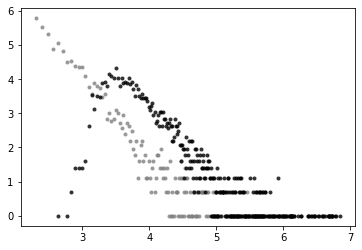

In [36]:
results = powerlaw.Fit(degseq)
alpha = results.power_law.alpha
xmin = results.power_law.xmin
R, p_value = results.distribution_compare('power_law', 'lognormal')
print("DEGREE: user p_value:", p_value, "user alpha:", alpha, "user xmin:", xmin)
plt.plot(np.log(xind),np.log(degseq),'o',color = 'gray', alpha = 0.8, markersize=4, markeredgewidth=0.0)

results = powerlaw.Fit(weiseq)
alpha = results.power_law.alpha
xmin = results.power_law.xmin
R, p_value = results.distribution_compare('power_law', 'lognormal')
print("WEIGHT: user p_value:", p_value, "user alpha:", alpha, "user xmin:", xmin)
plt.plot(np.log(xind),np.log(weiseq[:len(xind)]),'o',color = 'black', alpha = 0.8, markersize=4, markeredgewidth=0.0)

# Plot Item

In [37]:
degseq, weiseq, xind = a1.get_distribution("item")

user p_value: 0.9003255135178452 user alpha: 1.9691533706190696 user xmin: 14.0
user p_value: 0.4893608547744408 user alpha: 3.4157224238711605 user xmin: 19.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/acemap/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/home/acemap/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


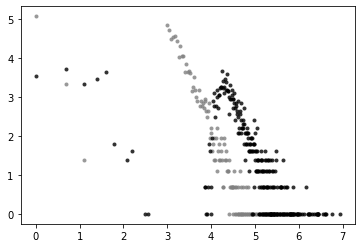

In [38]:
results = powerlaw.Fit(degseq)
alpha = results.power_law.alpha
xmin = results.power_law.xmin
R, p_value = results.distribution_compare('power_law', 'lognormal')
print("user p_value:", p_value, "user alpha:", alpha, "user xmin:", xmin)
plt.plot(np.log(xind),np.log(degseq),'o',color = 'gray', alpha = 0.8, markersize=4, markeredgewidth=0.0)

results = powerlaw.Fit(weiseq)
alpha = results.power_law.alpha
xmin = results.power_law.xmin
R, p_value = results.distribution_compare('power_law', 'lognormal')
print("user p_value:", p_value, "user alpha:", alpha, "user xmin:", xmin)
plt.plot(np.log(xind),np.log(weiseq[:len(xind)]),'o',color = 'black', alpha = 0.8, markersize=4, markeredgewidth=0.0)

# TMC-Needed Images

## 4 pic - User
 - $\beta-\alpha$
 - $R-\alpha$
 - $c_{u}-\alpha$
 - $c_{i}-\alpha$

In [51]:
beta_list = [0.1,0.2,0.4,0.6,0.8]
rate_list = [1,2,3,4,5,6,7,8,9,10]
cu_list = [1,5,10,20,30,50]
ci_list = [1,5,10,20,30,50]

### $\beta$

In [52]:
alpha_list = []
for item in beta_list:
    a1 = assumption_1st(beta=item,iterations=4000,rating_scale=5,Cu=10,Ci=20,Unum=20,Inum=10,K=10,L=5,C=1)
    degseq, weiseq, xind = a1.get_distribution()
    p_value, alpha, xmin = get_pvalue_alpha_xmin(degseq)
    alpha_list.append(alpha)
data=[alpha_list]
frame_beta_user=pd.DataFrame(data, index=[r'$ \beta $'+' effect '+r'$ \alpha $'], columns=beta_list)
frame_beta_user

Initalizing...Done.
Begin iteration...Done


TypeError: 'numpy.int64' object is not callable

### $rate$

In [63]:
alpha_list = []
for item in rate_list:
    a1 = assumption_1st(beta=0.6,iterations=4000,rating_scale=item,Cu=10,Ci=20,Unum=20,Inum=10,K=10,L=5,C=1)
    degseq, weiseq, xind = a1.get_distribution()
    p_value, alpha, xmin = get_pvalue_alpha_xmin(degseq)
    alpha_list.append(alpha)
data=[alpha_list]
frame_rate_user=pd.DataFrame(data, index=['rate'+' effect '+r'$ \alpha $'], columns=rate_list)
frame_rate_user

Initalizing...Done.
Begin iteration...Done
finish all the staff
p_value: 0.9944899073263794 alpha: 1.662488784353711 xmin: 2.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.32610584860721603 alpha: 1.6953862453912016 xmin: 1.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.5474560332032514 alpha: 1.6434840382680336 xmin: 4.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.7264935141181221 alpha: 1.6290824156976331 xmin: 2.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.7320629085284669 alpha: 1.615524033948358 xmin: 2.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.27662767762565654 alpha: 2.3293662908701194 xmin: 70.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.9433286074798366 alpha: 1.7558278588701646 xmin: 1.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.26565873226218173 alpha: 1.7748542947579562 xmin: 1.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.28275403031640944 alpha: 1.754065899738261 xmin: 1.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.24728155565057097 alpha: 1.6606865981384762 xmin: 1.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


,1,2,3,4,5,6,7,8,9,10
rate effect $ \alpha $,1.662489,1.695386,1.643484,1.629082,1.615524,2.329366,1.755828,1.774854,1.754066,1.660687


### $C_{u}$

In [64]:
alpha_list = []
for item in cu_list:
    print(item)
    a1 = assumption_1st(beta=0.6,iterations=4000,rating_scale=5,Cu=item,Ci=20,Unum=20,Inum=50,K=10,L=5,C=1)
    degseq, weiseq, xind = a1.get_distribution()
    p_value, alpha, xmin = get_pvalue_alpha_xmin(degseq)
    alpha_list.append(alpha)
data=[alpha_list]
frame_cu_user=pd.DataFrame(data, index=[r'$ c_{u} $'+' effect '+r'$ \alpha $'], columns=cu_list)
frame_cu_user

1
Initalizing...Done.
Begin iteration...Done
finish all the staff
p_value: 0.9263303235283947 alpha: 1.5828181555490235 xmin: 2.0
5
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.6959089087920705 alpha: 1.6192031841767123 xmin: 3.0
10
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.6843617976242241 alpha: 1.8774768178317403 xmin: 26.0
20
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.9549197748868207 alpha: 1.5943126817994715 xmin: 1.0
30
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.9398286002265938 alpha: 2.26826001331427 xmin: 43.0
50
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.22974396036622202 alpha: 1.4931462170190084 xmin: 1.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


,1,5,10,20,30,50
$ c_{u} $ effect $ \alpha $,1.582818,1.619203,1.877477,1.594313,2.26826,1.493146


### $C_{i}$

In [65]:
alpha_list = []
for item in ci_list:
    print(item)
    a1 = assumption_1st(beta=0.6,iterations=4000,rating_scale=5,Cu=10,Ci=item,Unum=50,Inum=10,K=10,L=5,C=1)
    degseq, weiseq, xind = a1.get_distribution()
    p_value, alpha, xmin = get_pvalue_alpha_xmin(degseq)
    alpha_list.append(alpha)
data=[alpha_list]
frame_ci_user=pd.DataFrame(data, index=[r'$ c_{i} $'+' effect '+r'$ \alpha $'], columns=ci_list)
frame_ci_user

1
Initalizing...Done.
Begin iteration...Done
finish all the staff
p_value: 0.5433155097875373 alpha: 1.805278913840811 xmin: 93.0
5
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.31816206139192615 alpha: 1.4808262742336231 xmin: 4.0
10
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.47874818503208527 alpha: 1.5449619135822745 xmin: 2.0
20
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.24979429954441468 alpha: 1.717625524729778 xmin: 1.0
30
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.7663506258848813 alpha: 1.866240254337272 xmin: 1.0
50
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.9062355542047932 alpha: 1.8887095910274714 xmin: 10.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


,1,5,10,20,30,50
$ c_{i} $ effect $ \alpha $,1.805279,1.480826,1.544962,1.717626,1.86624,1.88871


## 4 pic - Item
 - $\beta-\alpha$
 - $R-\alpha$
 - $c_{u}-\alpha$
 - $c_{i}-\alpha$

In [72]:
beta_list = [0.1,0.2,0.4,0.6,0.8]
rate_list = [1,2,3,4,5,6,7,8,9,10]
cu_list = [1,5,10,20,30,50]
ci_list = [1,5,10,20,30,50]

### $\beta$

In [67]:
alpha_list = []
for item in beta_list:
    a1 = assumption_1st(beta=item,iterations=4000,rating_scale=5,Cu=10,Ci=20,Unum=20,Inum=10,K=10,L=5,C=1)
    degseq, weiseq, xind = a1.get_distribution("item")
    p_value, alpha, xmin = get_pvalue_alpha_xmin(degseq)
    alpha_list.append(alpha)
data=[alpha_list]
frame_beta_item=pd.DataFrame(data, index=[r'$ \beta $'+' effect '+r'$ \alpha $'], columns=beta_list)
frame_beta_item

Initalizing...Done.
Begin iteration...Done
finish all the staff
p_value: 0.2670760702999915 alpha: 1.3219518579847875 xmin: 2.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.40504419461639285 alpha: 1.5729206842310084 xmin: 19.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.25871690170438255 alpha: 2.550479756350425 xmin: 139.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.9770284951160536 alpha: 1.6790304567433165 xmin: 1.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.3336612736553398 alpha: 2.283006598361551 xmin: 12.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


,0.1,0.2,0.4,0.6,0.8
$ \beta $ effect $ \alpha $,1.321952,1.572921,2.55048,1.67903,2.283007


### $rate$

In [68]:
alpha_list = []
for item in rate_list:
    a1 = assumption_1st(beta=0.6,iterations=4000,rating_scale=item,Cu=10,Ci=20,Unum=20,Inum=10,K=10,L=5,C=1)
    degseq, weiseq, xind = a1.get_distribution("item")
    p_value, alpha, xmin = get_pvalue_alpha_xmin(degseq)
    alpha_list.append(alpha)
data=[alpha_list]
frame_rate_item=pd.DataFrame(data, index=['rate'+' effect '+r'$ \alpha $'], columns=rate_list)
frame_rate_item

Initalizing...Done.
Begin iteration...Done
finish all the staff
p_value: 0.2972534287409978 alpha: 2.150829959686953 xmin: 35.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.3049297925604344 alpha: 2.2992245443748036 xmin: 43.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.9318096336239482 alpha: 1.643222315606932 xmin: 1.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.522035423877979 alpha: 2.2636397098854264 xmin: 48.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.3120378089211714 alpha: 2.220902562756679 xmin: 37.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.31854913694144193 alpha: 2.1256762191509493 xmin: 25.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.3002972585113738 alpha: 2.3695552591088287 xmin: 49.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.25837375785337957 alpha: 2.438995120994127 xmin: 54.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.9005717859207628 alpha: 1.9411473409843287 xmin: 16.0
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.3232449344287711 alpha: 1.6912266790324784 xmin: 1.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


,1,2,3,4,5,6,7,8,9,10
rate effect $ \alpha $,2.15083,2.299225,1.643222,2.26364,2.220903,2.125676,2.369555,2.438995,1.941147,1.691227


$C_{u}$

In [69]:
alpha_list = []
for item in cu_list:
    print(item)
    a1 = assumption_1st(beta=0.6,iterations=4000,rating_scale=5,Cu=item,Ci=20,Unum=20,Inum=50,K=10,L=5,C=1)
    degseq, weiseq, xind = a1.get_distribution("item")
    p_value, alpha, xmin = get_pvalue_alpha_xmin(degseq)
    alpha_list.append(alpha)
data=[alpha_list]
frame_cu_item=pd.DataFrame(data, index=[r'$ c_{u} $'+' effect '+r'$ \alpha $'], columns=cu_list)
frame_cu_item

1
Initalizing...Done.
Begin iteration...Done
finish all the staff
p_value: 0.9237947540175063 alpha: 2.000066205286622 xmin: 102.0
5
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.3795404152414623 alpha: 1.5797665079989107 xmin: 3.0
10
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.5005927303700729 alpha: 1.683418590929144 xmin: 1.0
20
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.40279627038291654 alpha: 1.9473115103866312 xmin: 1.0
30
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.8591032916420315 alpha: 1.9120742631743386 xmin: 6.0
50
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.9401014335210583 alpha: 1.9702045373891985 xmin: 5.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


,1,5,10,20,30,50
$ c_{u} $ effect $ \alpha $,2.000066,1.579767,1.683419,1.947312,1.912074,1.970205


$C_{i}$

In [70]:
alpha_list = []
for item in ci_list:
    print(item)
    a1 = assumption_1st(beta=0.6,iterations=4000,rating_scale=5,Cu=10,Ci=item,Unum=50,Inum=10,K=10,L=5,C=1)
    degseq, weiseq, xind = a1.get_distribution("item")
    p_value, alpha, xmin = get_pvalue_alpha_xmin(degseq)
    alpha_list.append(alpha)
data=[alpha_list]
frame_ci_item=pd.DataFrame(data, index=[r'$ c_{i} $'+' effect '+r'$ \alpha $'], columns=ci_list)
frame_ci_item

1
Initalizing...Done.
Begin iteration...Done
finish all the staff
p_value: 0.5858652718715328 alpha: 1.8094038462582436 xmin: 1.0
5
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.8716208302184627 alpha: 1.663018001947002 xmin: 2.0
10
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.9008464019549671 alpha: 1.8850906719112688 xmin: 16.0
20
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Begin iteration...Done
finish all the staff
p_value: 0.2945405033970372 alpha: 2.2593306847520385 xmin: 35.0
30
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.31970261659037424 alpha: 1.6798864553787607 xmin: 1.0
50
Initalizing...Done.


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


Begin iteration...Done
finish all the staff
p_value: 0.14689191154774411 alpha: 2.578826792223132 xmin: 40.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


,1,5,10,20,30,50
$ c_{i} $ effect $ \alpha $,1.809404,1.663018,1.885091,2.259331,1.679886,2.578827
